<h1><center>Отток клиентов мобильного оператора</center></h1>

# Введение

Цель проекта: За три месяца уменьшить отток пользователей на 15%

Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

Описание услуг
Оператор предоставляет два основных типа услуг:

    Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
    Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

    Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    Выделенная линия технической поддержки (TechSupport);
    Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных
Данные хранятся в таблицах в базе данных PostgreSQL:

    contract — информация о договоре,
    personal — персональные данные клиента,
    internet — информация об интернет-услугах,
    phone — информация об услугах телефонии.

Таблица telecom.contract

    customerID — ID пользователя,
    BeginDate — дата начала действия,
    EndDate — дата окончания действия,
    Type — тип оплаты (раз в год или помесячно),
    PaperlessBilling — безбумажный расчётный лист,
    PaymentMethod — тип платежа,
    MonthlyCharges — расход за месяц,
    TotalCharges — общие расходы.

Таблица personal

    customerID — ID пользователя,
    gender — пол,
    SeniorCitizen — является ли абонент пенсионером,
    Partner — есть ли у абонента супруг/супруга,
    Dependents — есть ли у абонента дети.

Таблица telecom.internet

    customerID — ID пользователя,
    InternetService — тип подключения,
    OnlineSecurity — блокировка небезопасных сайтов,
    OnlineBackup — облачное хранилище файлов для резервного копирования данных,
    DeviceProtection — антивирус,
    TechSupport — выделенная линия технической поддержки,
    StreamingTV — стриминговое телевидение,
    StreamingMovies — каталог фильмов.

Таблица telecom.phone

    customerID — ID пользователя,
    MultipleLines — подключение телефонного аппарата к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

Алгоритм работы:

    Загрузка данных
    Обработка данных
    Исследовательский анализ данных
    Обучение моделей
    Тестирование лучшей модели
    Общий вывод



Загрузим библиотеки

In [1]:
import sys
!!{sys.executable} -m pip install skorch
!!{sys.executable} -m pip install phik

['Collecting phik',
 '  Downloading phik-0.12.3-cp310-cp310-win_amd64.whl (663 kB)',
 '     -------------------------------------- 663.4/663.4 kB 1.3 MB/s eta 0:00:00',
 'Requirement already satisfied: numpy>=1.18.0 in c:\\python3100\\lib\\site-packages (from phik) (1.23.2)',
 'Requirement already satisfied: joblib>=0.14.1 in c:\\python3100\\lib\\site-packages (from phik) (1.2.0)',
 'Requirement already satisfied: scipy>=1.5.2 in c:\\python3100\\lib\\site-packages (from phik) (1.8.1)',
 'Requirement already satisfied: pandas>=0.25.1 in c:\\python3100\\lib\\site-packages (from phik) (1.4.2)',
 'Requirement already satisfied: matplotlib>=2.2.3 in c:\\python3100\\lib\\site-packages (from phik) (3.5.2)',
 'Requirement already satisfied: pyparsing>=2.2.1 in c:\\python3100\\lib\\site-packages (from matplotlib>=2.2.3->phik) (3.0.9)',
 'Requirement already satisfied: pillow>=6.2.0 in c:\\python3100\\lib\\site-packages (from matplotlib>=2.2.3->phik) (9.1.1)',
 'Requirement already satisfied: cy

In [2]:
import pandas as pd
import numpy as np
import random
import re

import torch 
import torch.nn as nn
import skorch

import phik
from phik.report import plot_correlation_matrix
from phik import report

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import (precision_recall_curve,
                            PrecisionRecallDisplay)

from torch.utils.data import TensorDataset 
from catboost import CatBoostClassifier
from skorch import NeuralNetClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## Загрузка данных

Создадим соеденение

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

Загрузим данные из таблицы contract

In [6]:
query_contract = '''
SELECT *
FROM telecom.contract
'''

contract_df = pd.read_sql_query(query_contract, con=engine) 
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


Все CustomerID уникальны

Загрузим данные из таблицы personal

In [7]:
query_personal = '''
SELECT *
FROM telecom.personal
'''

personal_df = pd.read_sql_query(query_personal, con=engine) 
personal_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Загрузим данные из таблицы internet

In [8]:
query_internet = '''
SELECT *
FROM telecom.internet
'''

internet_df = pd.read_sql_query(query_internet, con=engine) 
internet_df

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Header находится на первой строчке. Поменяем название колонок

In [9]:
internet_columns = internet_df.iloc[0].tolist()
internet_df.columns = internet_columns
internet_df = internet_df.drop([0]).reset_index(drop=True)
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Загрузим данные из таблицы phone

In [10]:
query_phone = '''
SELECT *
FROM telecom.phone
'''

phone_df = pd.read_sql_query(query_phone, con=engine) 
phone_df

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


Header находится на первой строчке. Поменяем название колонок

In [11]:
phone_columns = phone_df.iloc[0].tolist()
phone_df.columns = phone_columns
phone_df = phone_df.drop([0]).reset_index(drop=True)
phone_df


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Вывод: требуемые данные загружены, необходимы колонки имеются. Имеется общий ключ для объеденения таблиц - "CustomerID"

## Обработка данных

In [12]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Посмотрим кол-во уникальных пользователей

In [13]:
len(contract_df['customerID'].unique())

7043

Повторяющихся пользователей нет. Замержим информацию из других таблиц по customerID

In [14]:
user_info = contract_df.merge(personal_df, on='customerID', how='left')\
                       .merge(internet_df, on='customerID', how='left')\
                       .merge(phone_df, on='customerID', how='left')

Посмотрим кол-во отключений по месяцам

<AxesSubplot:>

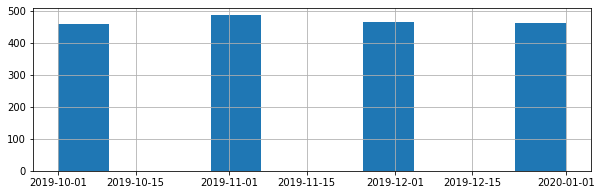

In [15]:
user_info['EndDate'].hist(figsize=(10,3))

Последние 4 месяца около 460 клиентов уходят каждый месяц. Т.е уход клентов не связан с определенным промежутком времени. Выделим их в наш таргет

In [16]:
user_info['target'] = 0
gone_client_index = user_info.loc[~user_info['EndDate'].isna()].index
user_info['target'].loc[gone_client_index] = 1
user_info['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

Всего ушло 1869 клиентов

Теперь посмотрим какое кол-во людей пользуется только интернетом, телефоном и обоими сервисами одновременно. Создадим колонку service c типами подключения: 'internet', 'phone', 'both'

In [17]:
user_info['internet'] = ''
user_info['phone'] = ''

user_info['internet'].loc[user_info['customerID'].isin(internet_df['customerID'])] = 'internet'
user_info['phone'].loc[user_info['customerID'].isin(phone_df['customerID'])] = 'phone'

In [18]:
user_info['service'] = user_info['internet'] + user_info['phone']
user_info['service'] = user_info['service'].map({'internetphone':'both', 'internet':'internet', 'phone':'phone'})

Проверим

In [19]:
user_info['service'].value_counts()

both        4835
phone       1526
internet     682
Name: service, dtype: int64

Проверим, если пользователи, которые не пользуются ни одним из сервисов

In [20]:
user_info['service'].isna().sum()

0

Удалим лишние колонки

In [21]:
user_info.drop(columns={'phone', 'internet'}, inplace=True)

Проверим

In [22]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Заполним пропуски по сервисам использования интернета и телефона константой 'None'

In [23]:
internet_fill_na_constant = 'No'

user_info.fillna({
                'InternetService': internet_fill_na_constant,
                'OnlineSecurity': internet_fill_na_constant,
                'OnlineBackup': internet_fill_na_constant,
                'DeviceProtection': internet_fill_na_constant,
                'TechSupport': internet_fill_na_constant,
                'StreamingTV': internet_fill_na_constant,
                'StreamingMovies': internet_fill_na_constant
                }, inplace=True)

phone_fill_na_constant = 'No'

user_info.fillna({
                'MultipleLines': phone_fill_na_constant,
                }, inplace=True)

Удалим записи с пропущенным значением TotalCharges

In [24]:
user_info.dropna(subset=['TotalCharges'], inplace=True)
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 2 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   7032 non-null   object 
 13  OnlineSecurity    7032 non-null   object 
 14  OnlineBackup      7032 non-null   object 
 15  DeviceProtection  7032 non-null   object 
 16  TechSupport       7032 non-null   object 


Переведем колонки с датой в соответствующий тип

In [25]:
user_info['BeginDate'] = pd.to_datetime(user_info['BeginDate'])
user_info['EndDate'] = pd.to_datetime(user_info['EndDate'])

Выделим количественные, временные и категориальные фичи

In [26]:
num_features = ['MonthlyCharges', 'TotalCharges']
date_features = ['BeginDate', 'EndDate']
id_features = ['customerID']
categorial_features = list(set(user_info.columns.tolist()) - set(num_features) - set(date_features) - set(id_features))

In [27]:
print(categorial_features)

['Type', 'StreamingTV', 'Dependents', 'OnlineSecurity', 'target', 'gender', 'DeviceProtection', 'OnlineBackup', 'InternetService', 'service', 'StreamingMovies', 'Partner', 'MultipleLines', 'SeniorCitizen', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']


Переведем категориальные фичи в соответствующий формат

In [28]:
user_info[categorial_features] = user_info[categorial_features].astype('category')
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 2 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7032 non-null   category      
 4   PaperlessBilling  7032 non-null   category      
 5   PaymentMethod     7032 non-null   category      
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   category      
 9   SeniorCitizen     7032 non-null   category      
 10  Partner           7032 non-null   category      
 11  Dependents        7032 non-null   category      
 12  InternetService   7032 non-null   category      
 13  OnlineSecurity    7032 non-null   category      
 14  OnlineBackup      7032 n

Посчитаем кол-во месяцев использование подписки

Там, где нет даты, поставим конечную в датасете

In [29]:
user_info['EndDate'].loc[user_info['EndDate'].isna()] = '2020-02-01'
user_info['EndDate'] = pd.to_datetime(user_info['EndDate'])

In [30]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 2 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   category      
 4   PaperlessBilling  7032 non-null   category      
 5   PaymentMethod     7032 non-null   category      
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   category      
 9   SeniorCitizen     7032 non-null   category      
 10  Partner           7032 non-null   category      
 11  Dependents        7032 non-null   category      
 12  InternetService   7032 non-null   category      
 13  OnlineSecurity    7032 non-null   category      
 14  OnlineBackup      7032 n

In [31]:
user_info['months'] = (user_info['EndDate'] - user_info['BeginDate']) / np.timedelta64(1, 'M')
user_info['months'] = user_info['months'].astype(int)
user_info['months'].head()

2     15
4      9
5     10
8      6
12    10
Name: months, dtype: int32

Вывод: Мы соеденили таблицы, удалили пропуски в столбце TotalCharges. Создадили фичу 'months', показывающую время использования сервиса в месяцах, создали категориальную фичу 'service', указывающую какие услуги(телефон или интернет), использует клиент

## Исследовательский анализ

Сравним, сколько дней использовали сервис ушедшие и текущие клиенты

<AxesSubplot:xlabel='months', ylabel='Count'>

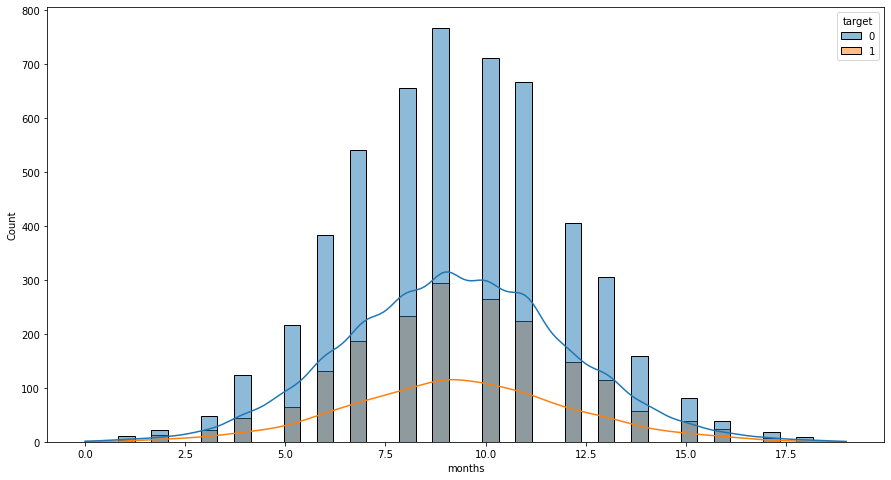

In [32]:
plt.figure(figsize=(15,8))
sns.histplot(data=user_info, x="months", hue="target", kde=True)

Одинаковое нормальные распределение в обоих случаях. Т.е уход клиентов не может быть вызван скидочный акцией, после периода которой они перестали использовать услуги сервиса

Сравним кол-во текущих клиентов и ушедших по типу использования сервиса (только интернет, телефон, или оба)

<AxesSubplot:xlabel='service', ylabel='Count'>

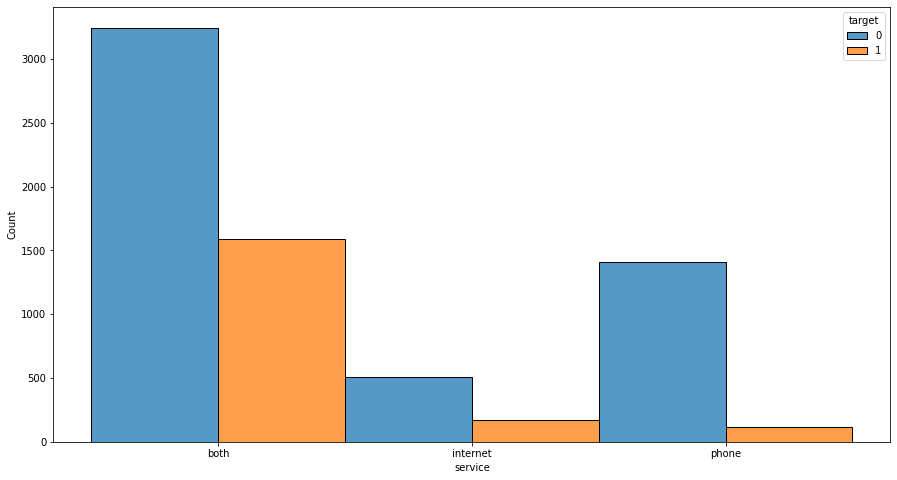

In [33]:
plt.figure(figsize=(15,8))
sns.histplot(data=user_info, x='service', hue="target", multiple='dodge')

Меньше всего уходят клиенты, использующие только телефон, затем только интернет, и большая часть, которые используют и то, и другое

Сравним распределения величин ежемесячных платежей всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитаем: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

In [34]:
current_users_monthly_info = user_info[user_info['target'] == 0]['MonthlyCharges'].describe()
gone_users_monthly_info = user_info[user_info['target'] == 1]['MonthlyCharges'].describe()

users_monthly_compare = pd.concat([current_users_monthly_info, gone_users_monthly_info], axis=1)
users_monthly_compare.columns = ['current_users', 'gone_users']
users_monthly_compare['difference'] = users_monthly_compare['current_users'] - users_monthly_compare['gone_users']
users_monthly_compare

,current_users,gone_users,difference
count,5163.000000,1869.000000,3294.000000
mean,61.307408,74.441332,-13.133924
std,31.094557,24.666053,6.428504
min,18.250000,18.850000,-0.600000
25%,25.100000,56.150000,-31.050000
50%,64.450000,79.650000,-15.200000
75%,88.475000,94.200000,-5.725000
max,118.750000,118.350000,0.400000


Почти по всем показателям можно сделать вывод, что ушедшие пользователи в среднем имели более дорогую ежемесячную ставку, чем действующие клиенты. Особенно большая разница в 25% квартиле.

Посмотрим основные параметры и построим гистограмму распределения общих платежей за данный период для каждой из групп

In [35]:
user_info['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

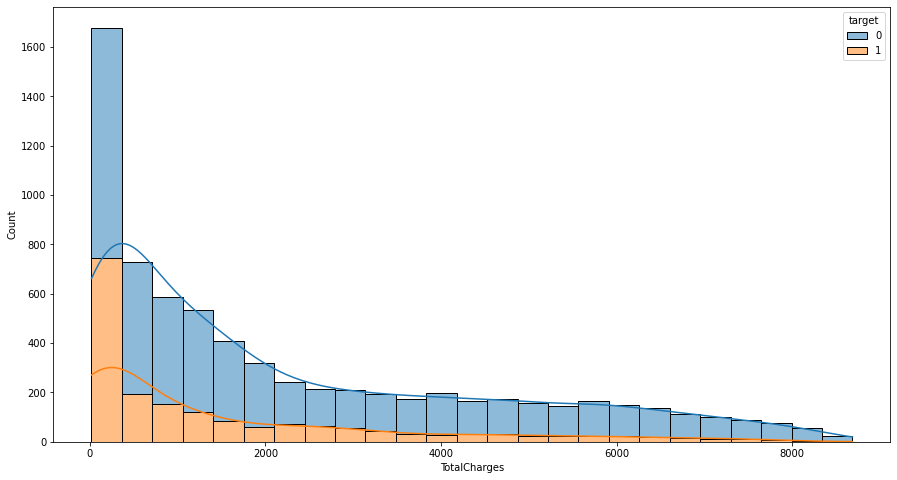

In [36]:
plt.figure(figsize=(15,8))
sns.histplot(data=user_info, x='TotalCharges', hue="target", multiple="stack", kde=True)

Большая часть клиентов уходит в первый месяц использования, в дальшейшем их количество снижается

Построим гистограмму распределения ежемесячных платежей для каждой из групп

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

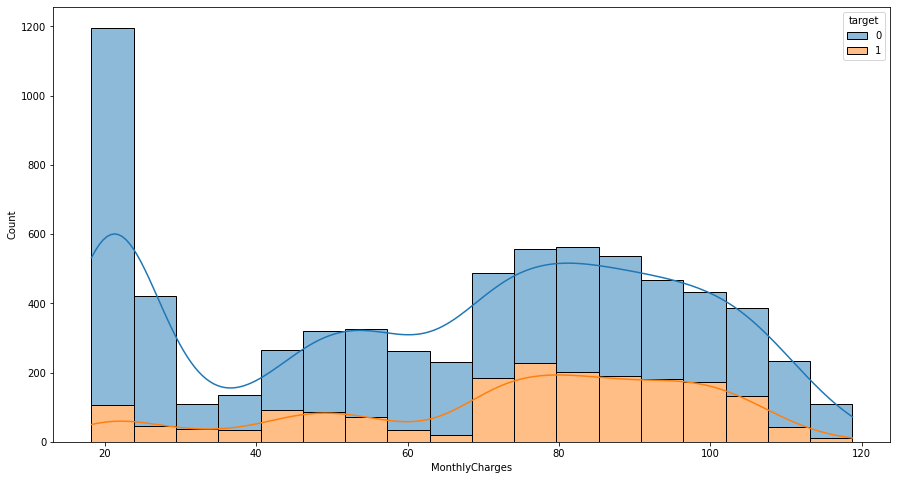

In [37]:
plt.figure(figsize=(15,8))
sns.histplot(data=user_info, x='MonthlyCharges', hue="target", multiple="stack", kde=True)

Среди пользователи, покупающих дополнительные услуги сервиса, и следовательно, имеющие более высокую ежемесячную оплату, гораздо больше недовольных, чем среди тех, кто этого не делает. Следовательно, можно предположить, что клиентов не устраивает соотношение цены\качество дополнительных услуг, предоставляемых компанией

Посмотрим мультиколлинеарность признаков, использую библиотеку phik

In [38]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'months']
user_info_corr = user_info.drop(columns={'EndDate', 'BeginDate', 'customerID'})
user_info_corr_num = user_info_corr[interval_cols]
user_info_corr_cat = user_info_corr[categorial_features]

In [39]:
phik_num = user_info_corr_num.phik_matrix(interval_cols=interval_cols)
phik_cat = user_info_corr_cat.phik_matrix(interval_cols=interval_cols)

Построим матрицу корреляций для количественных признаков

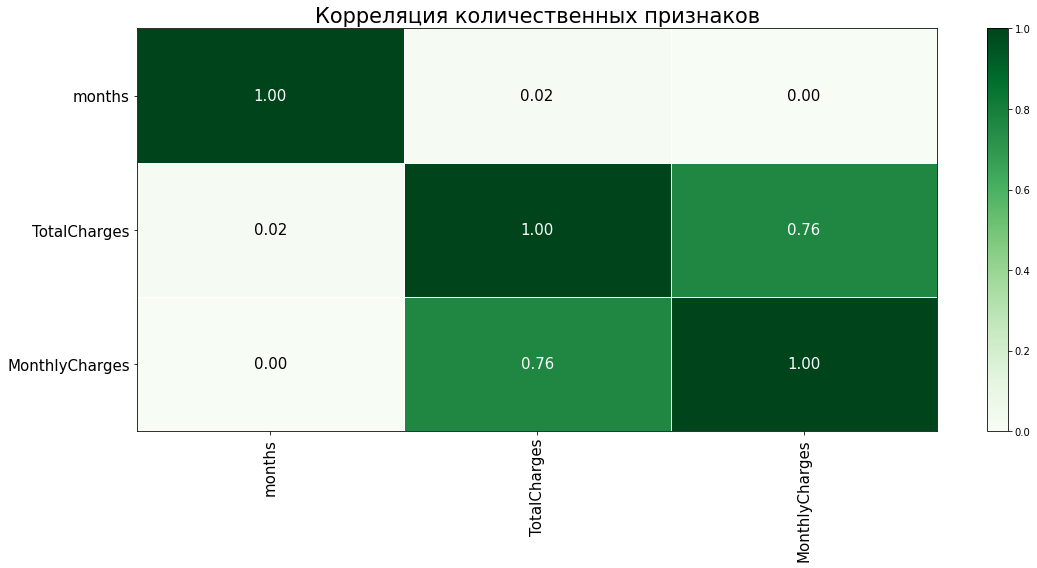

In [40]:
plot_correlation_matrix(phik_num.values, 
                        x_labels=phik_num.columns, 
                        y_labels=phik_num.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция количественных признаков", 
                        fontsize_factor=1.5,
                        figsize=(16, 8))
plt.tight_layout()

По понятным причинам высокая корреляция между 'TotalCharges' и 'MonthlyCharges'. Но нельзя однозначно сказать, что клиент, выбравший большое кол-во услуг(MonthlyCharges), будет долго пользоваться сервисом(TotalCharges) 

Построим матрицу корреляций для категориальных признаков

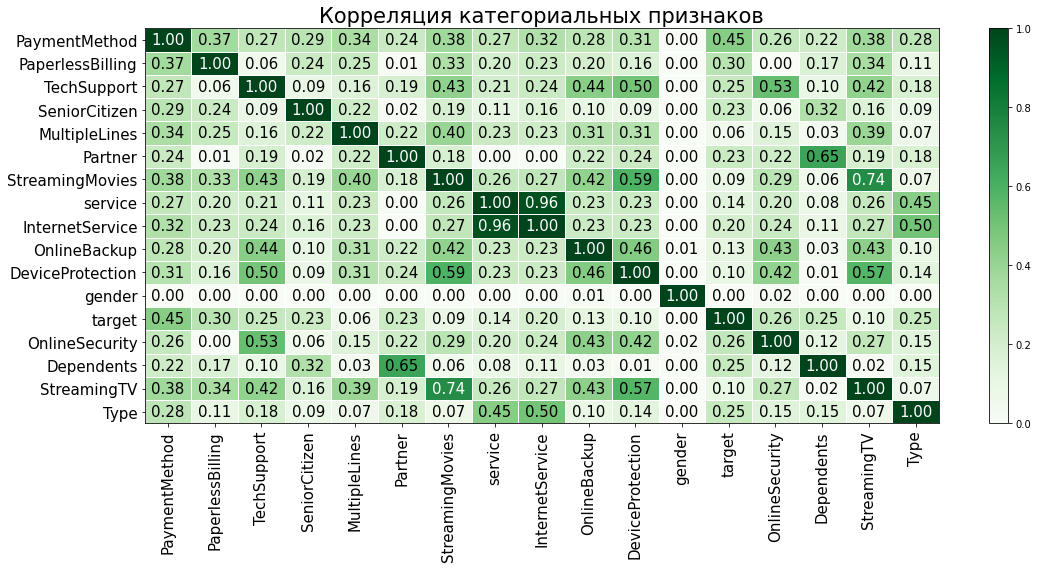

In [41]:
plot_correlation_matrix(phik_cat.values, 
                        x_labels=phik_cat.columns, 
                        y_labels=phik_cat.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция категориальных признаков", 
                        fontsize_factor=1.5,
                        figsize=(16, 8))
plt.tight_layout()

Высокая мультиколлинеарность между 'service' и 'InternetService'. Удалим при обучении один из этих признаков

Вывод: большое кол-во клиентов уходят после первого месяца использования. В основном уходят клиенты, подключившие большое кол-во доп услуг

## Построение модели

Уберем ненужные фичи и выделим таргет

In [42]:
y = user_info['target']
X = user_info.drop(columns={'customerID', 'BeginDate', 'EndDate', 'target', 'InternetService'})

Разделим на тест и трейн

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=231022)

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 2 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7032 non-null   category
 1   PaperlessBilling  7032 non-null   category
 2   PaymentMethod     7032 non-null   category
 3   MonthlyCharges    7032 non-null   float64 
 4   TotalCharges      7032 non-null   float64 
 5   gender            7032 non-null   category
 6   SeniorCitizen     7032 non-null   category
 7   Partner           7032 non-null   category
 8   Dependents        7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  MultipleLines     7032 non-null   category
 16  service           7032 n

Выделим количественные и категориальные фичи

In [45]:
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(include='category').columns.tolist()

Будем решать задачу классификации и обучим RandomForest, Catboost и полносвязную нейронную сеть

Сделаем предпроцессинг. Для количественных фичей будем делать MinMaxScaler. Для категориальных OneHotEncoder

In [46]:
cat_transformer_linear = OneHotEncoder(handle_unknown='error', drop='first')
cat_transformer_tree = OrdinalEncoder(handle_unknown='ignore')
num_transformer = MinMaxScaler()

preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer_linear, cat_features)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer_tree, cat_features)
    ]
)

pipeline_preprocessor_linear = Pipeline([('preprocessor', preprocessor_linear)])   

Для того, что интергрировать в sklearn GridSearchCV нейронную сеть, воспользуемся библиотекой skorch. Создадим простую модель из 2ух скрытых слоев и выходного c сигмойдной функцией активации. Количество эпох возьмем равным 5

In [47]:
torch.manual_seed(231022)
torch.use_deterministic_algorithms(True)

net_epochs = 5
n_in_neurons = pipeline_preprocessor_linear.fit_transform(X_train).shape[1]
n_out_neurons = 1

class MyModule(nn.Module):
    def __init__(self,
                 n_in_neurons=n_in_neurons,
                 n_hidden_neurons_1=10,
                 n_hidden_neurons_2=8,
                 n_out_neurons=n_out_neurons):
                 
        super(MyModule, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)        
        self.act3 = nn.Sigmoid() 

    def forward(self, x):
      x = self.fc1(x)
      x = self.act1(x)
      x = self.fc2(x)
      x = self.act2(x)
      x = self.fc3(x)
      x = self.act3(x)
      return x 


net = NeuralNetClassifier(
    MyModule,
    max_epochs=net_epochs,
    criterion=torch.nn.BCELoss,
    verbose=0
)

Сделаем пайплайны для каждой из моделей. Для Catboost не будем делать предпроцессинг, т.к у него свои методы работы с категориальными и количественными фичами. Для нейронной сети предпроцессинг вынесен в функцию ниже

In [48]:
pipeline_tree = Pipeline([('preprocessor', preprocessor_tree),
                          ('tree', None)])

pipeline_catboost = Pipeline([('catboost', None)])      

pipeline_net = Pipeline([('net', None)])

Сделаем сетки для перебора гиперпараметров для каждой из моделей<br>
<br>
Для деревьев:

    количество деревьев
    глубина

Для бустинга:

    количество деревьев
    глубина
    лернинг рейт

Для нейронной сети:

    лернинг рейт
    количество нейроной первого скрытого слоя
    количество нейроной второго скрытого слоя

In [49]:
param_tree = {
     'tree': (RandomForestClassifier(random_state=231022),),
     'tree__n_estimators': [200, 300, 500],
     'tree__max_depth': [10, 20, 30],
     }


param_catboost = {
    'catboost': (CatBoostClassifier(random_state=231022, 
                                     verbose=0,
                                     od_type='Iter',
                                     od_wait=10,
                                     cat_features=cat_features,),),
     'catboost__n_estimators': [100, 200],
     'catboost__max_depth': [4, 6],
     'catboost__learning_rate': [0.05, 0.1]
     }


param_net = {
    'net': (net,),
    'net__lr': [0.01, 0.05],
    'net__module__n_hidden_neurons_1': [32, 16],
    'net__module__n_hidden_neurons_2': [10, 6]
}

Подготовим все для GridSearchCV

In [50]:
pipelines = [pipeline_tree, pipeline_catboost, pipeline_net]
param_grids = [param_tree, param_catboost, param_net]
names = ['tree', 'catboost', 'net']

Напишем функцию для фита в GridSearch и выведение результатов на экран. Будем использовать метрику roc-auc. Кросс-валидацию сделаем 3, чтобы не тратить много времени. Для нейронной сети будем отдельно делать предпроцессинг и перевод в тензорный тип

In [51]:
def gs_and_result(pipeline, param_grid, name, cv, n_jobs):
    gs = GridSearchCV(pipeline,
                      param_grid,
                      scoring='roc_auc',
                      n_jobs=n_jobs,
                      refit='roc_auc',
                      cv=cv)

    #change data to tensors if we fit net
    if (name == 'net'):
        X_train_tensor = torch.FloatTensor(pipeline_preprocessor_linear.fit_transform(X_train, y_train))
        y_train_tensor = torch.Tensor(np.array(y_train)).reshape(-1, 1)
        gs.fit(X_train_tensor, y_train_tensor)
    else:
        gs.fit(X_train, y_train)

    #top models table
    print('Top ' + name + ' models:')
    results_df = pd.DataFrame(gs.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])

    #display for tree model
    if (name == 'tree'):    
        params = results_df["params"].apply(pd.Series).to_dict()
        keys = list(params.keys())
        results_df["max_depth"] = params[keys[1]].values()
        results_df["max_estimators"] = params[keys[2]].values()

        display(results_df[["max_depth", "max_estimators", 'mean_test_score', 'rank_test_score']]
                .head(5)
                .rename(columns={'mean_test_score': 'cv_score'})
                .rename(columns={'rank_test_score': 'rank_cv_score'}))

    #display for catboost model
    if (name == 'catboost'):    
        params = results_df["params"].apply(pd.Series).to_dict()
        keys = list(params.keys())
        results_df["lr"] = params[keys[1]].values()
        results_df["max_depth"] = params[keys[2]].values()
        results_df["max_estimators"] = params[keys[3]].values()

        display(results_df[['lr', "max_depth", "max_estimators", 'mean_test_score', 'rank_test_score']]
                .head(5)
                .rename(columns={'mean_test_score': 'cv_score'})
                .rename(columns={'rank_test_score': 'rank_cv_score'}))

    #display for net model
    if (name == 'net'):    
        params = results_df["params"].apply(pd.Series).to_dict()
        keys = list(params.keys())
        results_df["lr"] = params[keys[0]].values()
        results_df["n_hidden_neurons_1"] = params[keys[1]].values()
        results_df["n_hidden_neurons_2"] = params[keys[2]].values()

        display(results_df[["lr", 'n_hidden_neurons_1', 'n_hidden_neurons_2', 'mean_test_score', 'rank_test_score']]
                .head(5)
                .rename(columns={'mean_test_score': 'cv_score'})
                .rename(columns={'rank_test_score': 'rank_cv_score'})) 

    #best cv score
    print('Best cv score of ' + name + ' model:')
    print(round(gs.best_score_, 3))
    print()
  
    return gs   

Посмотрим результат. Для каждой модели выведем топ-5 лучших

In [52]:
cv = 3
n_jobs = 10

best_estimators = {}
for pipeline, param_grid, name in zip(pipelines, param_grids, names):   
    best_estimators[name] = gs_and_result(pipeline, param_grid, name, cv, n_jobs).best_estimator_

ValueError: 
All the 27 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python3100\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Python3100\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\compose\_column_transformer.py", line 726, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "c:\Python3100\lib\site-packages\sklearn\compose\_column_transformer.py", line 657, in _fit_transform
    return Parallel(n_jobs=self.n_jobs)(
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Python3100\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "c:\Python3100\lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\base.py", line 851, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "c:\Python3100\lib\site-packages\sklearn\preprocessing\_encoders.py", line 1213, in fit
    self._validate_params()
  File "c:\Python3100\lib\site-packages\sklearn\base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "c:\Python3100\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'handle_unknown' parameter of OrdinalEncoder must be a str among {'error', 'use_encoded_value'}. Got 'ignore' instead.

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python3100\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Python3100\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\compose\_column_transformer.py", line 726, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "c:\Python3100\lib\site-packages\sklearn\compose\_column_transformer.py", line 657, in _fit_transform
    return Parallel(n_jobs=self.n_jobs)(
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Python3100\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "c:\Python3100\lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Python3100\lib\site-packages\sklearn\base.py", line 851, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "c:\Python3100\lib\site-packages\sklearn\preprocessing\_encoders.py", line 1213, in fit
    self._validate_params()
  File "c:\Python3100\lib\site-packages\sklearn\base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "c:\Python3100\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'handle_unknown' parameter of OrdinalEncoder must be a str among {'use_encoded_value', 'error'}. Got 'ignore' instead.


Лучшая модель: catboost

In [ ]:
best_model = best_estimators['catboost']

Вывод: Мы взяли 3 типа моделей: decision tree, catboost, neural network и, перебрав гиперпаметры, нашли среди них наилучшую модель. Ее оказался catboost

## Тестирование модели

Посмотрим результат на тесте. Посчитаем roc-auc и accuracy

In [ ]:
print('Test roc-auc score:')
print(round(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]), 3))
print()
print('Test accuracy score:')
print(round(accuracy_score(y_test, best_model.predict(X_test)), 3))

Test roc-auc score:
0.867

Test accuracy score:
0.825


Построим матрицу ошибок, найдем параметры, которые сильнее всего влияют на таргет

In [ ]:
preds = best_model.predict(X_test)

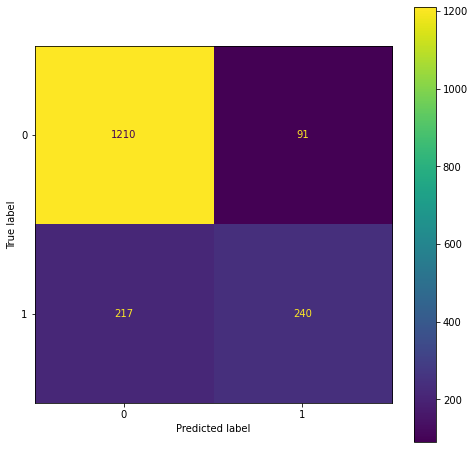

In [ ]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)                    

На нашей тестовой выборки модель 235 раз правильно обнаружила "уходящего" клиента и в 99 случаях ошиблась. Итого, мы получили precision в 70%. Если компания будет тратить дополнительно средства на удержания потенциально "уходящих" клиентов, хватит ли ей этого показателя, чтобы данные меры принесли прибыль, не ясно, т.к мы не располагаем информацией о бизнес-модели данного оператора

Построим график precision/recall

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, preds)

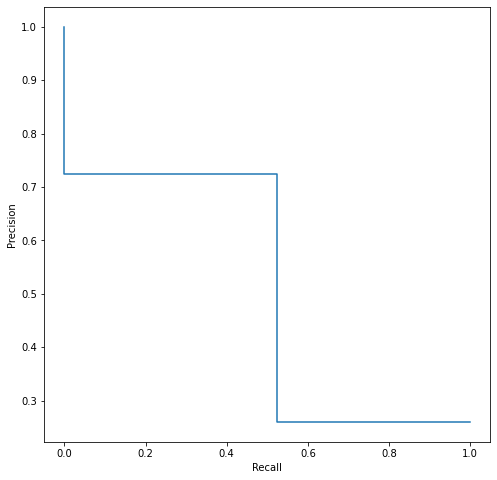

In [ ]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax) 

Посмотрим feature importance

In [ ]:
pd.Series(best_model[0].feature_importances_, index=X_test.columns).sort_values(ascending=False)

Type                33.348184
MonthlyCharges      20.230140
TotalCharges        16.583968
service              9.178970
OnlineSecurity       3.846911
PaymentMethod        3.745931
PaperlessBilling     3.025422
months               2.461393
TechSupport          1.591507
StreamingMovies      1.160824
MultipleLines        1.045106
SeniorCitizen        0.848913
OnlineBackup         0.790970
gender               0.631704
Dependents           0.615623
StreamingTV          0.400576
Partner              0.387068
DeviceProtection     0.106791
dtype: float64

Построим для первых трех графики зависимости от таргета

MonthlyCharges:

(0.0, 1200.0)

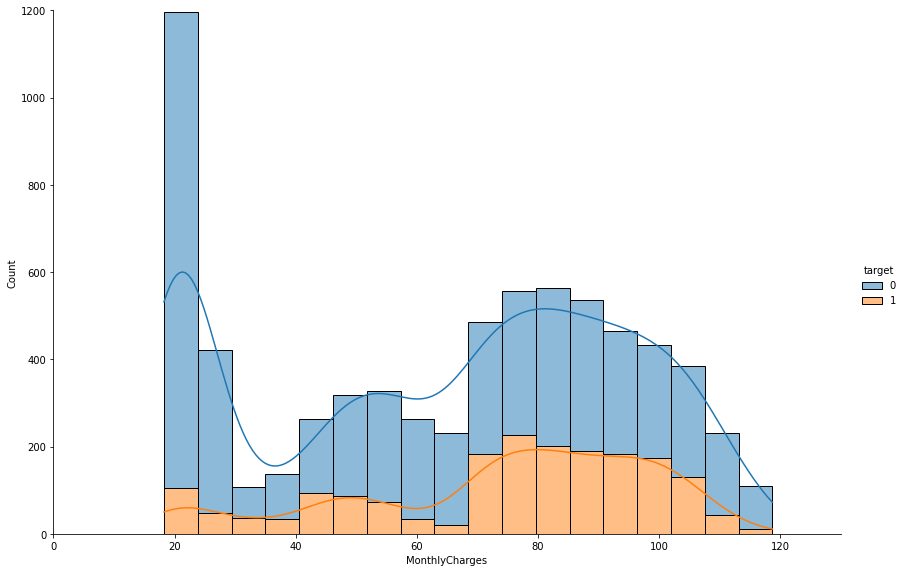

In [ ]:
sns.displot(data=user_info, x="MonthlyCharges", hue='target', kde=True, height=8, multiple='stack', aspect=1.5)
plt.xlim(0, 130)
plt.ylim(0, 1200)

Тот же график, что и в разделе исследования данных

TotalCharges:

(0.0, 1700.0)

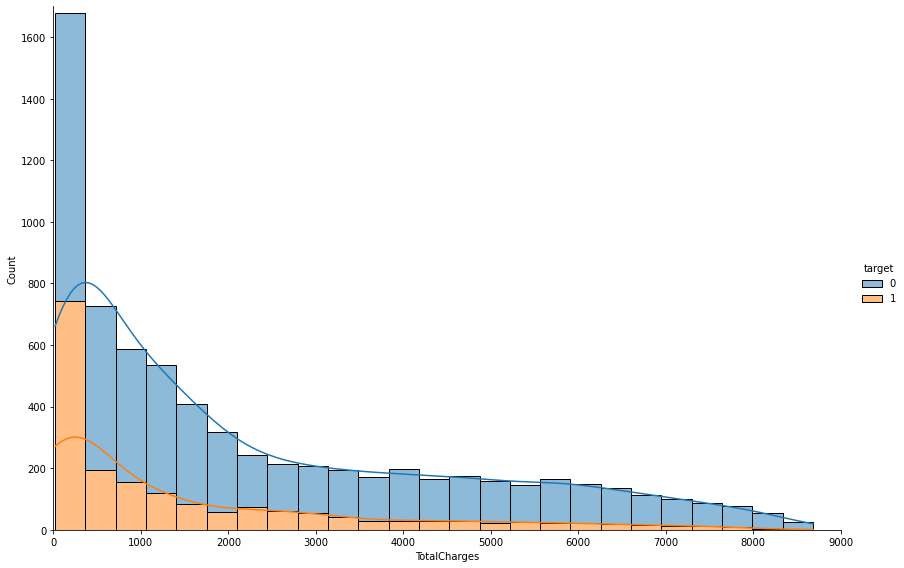

In [ ]:
sns.displot(data=user_info, x="TotalCharges", hue='target', kde=True, height=8, aspect=1.5, multiple='stack')
plt.xlim(0, 9000)
plt.ylim(0, 1700)

Тот же график, что и в разделе исследования данных

Type:

<AxesSubplot:xlabel='Type', ylabel='Count'>

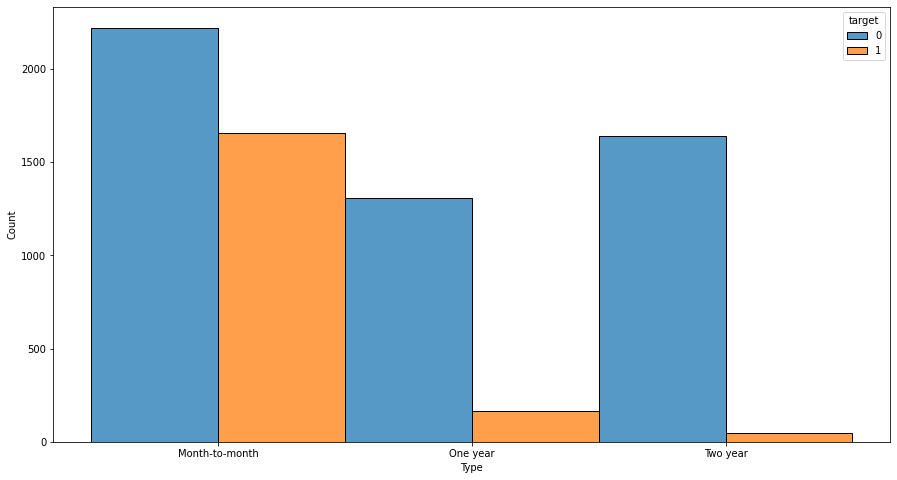

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=user_info, x='Type', hue="target", multiple='dodge')

Вывод: В основном, уходят пользователи, использующие помесячную оплату. Т.е те, которые захотели попробовать сервис и разочаровались в цене\условиях\качестве предоставляемых услуг

## Общий вывод и рекомендации

Целью исследования было построение модели, предсказывающий возможный уход клиента сервиса. Нам были даны исторические данные небольшого временного промежутка. Мы сделали предподготовку данных, почистив сет от пропусков, добавили новые фичи.<br>

Далее, использовав метрику roc-auc, построили ряд моделей из следующих классов: decision tree, boosting, neural network. Для получения лучшего результата, мы использовали перебор гиперпараметров и кросс-валидацию.<br>
Лучшие результаты показала модель catboost с параметрами:

    learning rate:  0.05
    max depth:      4
    max estimators: 200
    
Она показала результат 0.867 на тестовой выборке.<br>
Далее мы посмотрели, какие параметры влияют на возможный шанс ухода клиента.<br>
Ими оказались:

    'MonthlyCharges'
    'TotalCharges'
    'Type'

Мы построили графики их зависимости от таргета и пришли к выводу, ушедшие клиенты в среднем обладают следующими свойствами:

    - новые клиенты
    - помесячный тип оплаты, т.е те, которые хотят посмотреть, подходит им сервис или нет
    - подключающие дополнительные услуги, возможно, ради них они и решили воспользоваться провайдером

На основе этого мы предлагаем следующие рекомендации:

    - более комфортные условия\скидки новым клиентам
    - акции на приобретения годового, 2-ух годового пакета, т.к среди этих клиентов отток значительно меньше по понятным причинам
    - посмотреть на соотношение цены\качества предоставляемых услуг
    

